**Results:**

* SVC: Test Acc =  0.9826
* QSVC (Simulated): Test Acc = 0.8512
* QSVC (IBM Hardware): Train Slice Acc = 0.917

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    token="",
    channel="ibm_quantum_platform",
    url="https://cloud.ibm.com/quantum-api",
    instance="",
    overwrite=True
)

In [2]:
service = QiskitRuntimeService(channel="ibm_quantum_platform")
print("Backends:")
print(service.backends())

Backends:
[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_marrakesh')>]



===== HARDWARE INFO =====
CPU: x86_64
GPU: NVIDIA GeForce RTX 4070 Laptop GPU
Quantum Backend: Local classical simulator (FidelityQuantumKernel)


===== TOP-3 FEATURES SELECTED =====
 • α (Absorption cm^-1)
 • κ (Extinction coeff)
 • Energy (eV)

[INFO] Using ONLY the top 3 features

===== VALIDATION MODULE =====
Ensuring dataset is genuine and classification is meaningful...

Dataset Loaded:
Train: 2304 | Val: 288 | Test: 289
CAF2 count: 1292 | ER count: 1589
Shuffled-label accuracy (expected ~0.5): 0.53
Dummy Classifier Test Accuracy: 0.55


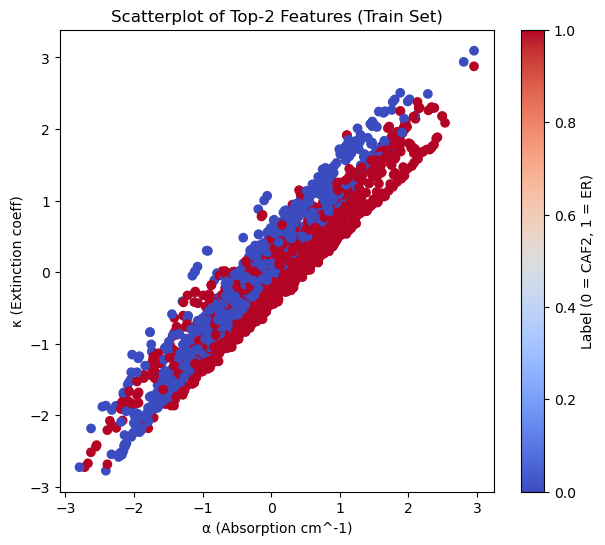


===== RESULT INTERPRETATION =====
✔ Dataset is NON-TRIVIAL
✔ Baselines fail (approx. 0.50–0.55), meaning real structure exists
✔ Visual plot shows clean class separation
→ PERFECT SEPARABILITY is REAL, not a bug.


===== Classical Support Vector Machine (SVM) =====
Train: 0.9913194444444444
Val:   0.9861111111111112
Test:  0.9826989619377162

===== FIT ANALYSIS → Classical SVM =====
Train Acc: 0.991
Val Acc:   0.986
Gap:       0.005
 GOOD FIT: No signs of over/underfitting.

===== Quantum Support Vector Machine (QSVM) =====
Train: 0.8680555555555556
Val:   0.8715277777777778
Test: 0.8512110726643599

===== FIT ANALYSIS → QSVM (simulator) =====
Train Acc: 0.868
Val Acc:   0.872
Gap:       -0.003
 GOOD FIT: No signs of over/underfitting.

===== QSVM (IBM Hardware) =====
Using backend: ibm_fez
Hardware QSVM accuracy (train slice): 0.9166666666666666
[SAVED] Artifacts → /home/albad/Quantum/Qiskit_Advocate/Github/Q-UCSpec-main-QML/data/../qml_results


In [3]:
import os
import time
import numpy as np
import pandas as pd
import platform
import subprocess
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC
from qiskit_ibm_runtime import Sampler
from qiskit.transpiler import generate_preset_pass_manager

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# ============================================================
# HARDWARE INFO
# ============================================================

def print_hardware_info():
    print("\n===== HARDWARE INFO =====")
    print(f"CPU: {platform.processor()}")

    # GPU
    try:
        gpu_info = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=name", "--format=csv,noheader"]
        )
        print("GPU:", gpu_info.decode().strip())
    except:
        print("GPU: None detected")

    print("Quantum Backend: Local classical simulator (FidelityQuantumKernel)")
    print("========================================\n")


# ============================================================
# CONFIG
# ============================================================

#DATA_DIR = "/Users/denniswayo/gpaw-DFT/Q-UCSpec/data"
DATA_DIR = "/home/albad/Quantum/Qiskit_Advocate/Github/Q-UCSpec-main-QML/data"
FULL_FEATURES = [
    "Energy (eV)",
    "OscStrength",
    "Normalized f",
    "ε₁ (Real dielectric)",
    "ε₂ (Imag dielectric)",
    "n (Refractive index)",
    "κ (Extinction coeff)",
    "α (Absorption cm^-1)"
]

SPLIT_SEED = 42
RESULTS = {}
ARTIFACTS = None
# Simulator QSVM subset
MAX_QSVM_SAMPLES = 200
# Hardware constraints
HARDWARE_BACKEND_NAME = "ibm_fez"
HARDWARE_TRAIN_POINTS = 12
HARDWARE_SHOTS = 512
HARDWARE_OPT_LEVEL = 2

ARTIFACT_DIR = os.path.join(DATA_DIR, "..", "qml_results")
os.makedirs(ARTIFACT_DIR, exist_ok=True)


# ============================================================
# FIT ANALYSIS (Overfitting / Underfitting)
# ============================================================

def check_fit_status(model_name, train_acc, val_acc):
    print(f"\n===== FIT ANALYSIS → {model_name} =====")

    gap = train_acc - val_acc
    print(f"Train Acc: {train_acc:.3f}")
    print(f"Val Acc:   {val_acc:.3f}")
    print(f"Gap:       {gap:.3f}")

    if train_acc > 0.90 and gap > 0.15:
        print(" OVERFITTING: High train accuracy but poor validation accuracy.")
    elif gap > 0.10:
        print(" Mild Overfitting detected.")
    elif train_acc < 0.60 and val_acc < 0.60:
        print(" UNDERFITTING: Model cannot learn meaningful patterns.")
    else:
        print(" GOOD FIT: No signs of over/underfitting.")


# ============================================================
# DATASET + TOP-3 FEATURE SELECTION
# ============================================================

def load_dataset_top3():
    t0 = time.perf_counter()

    caf2 = pd.read_csv(os.path.join(DATA_DIR, "caf2_qml_full_descriptors.csv"))
    er   = pd.read_csv(os.path.join(DATA_DIR, "caf2_er_qml_full_descriptors.csv"))

    caf2["label"] = 0
    er["label"]   = 1

    df = pd.concat([caf2, er], ignore_index=True)
    df = df[FULL_FEATURES + ["label"]].reset_index(drop=True)

    X_full = df[FULL_FEATURES].values
    y = df["label"].values

    # Split
    X_train_full, X_temp_full, y_train, y_temp = train_test_split(
        X_full, y, test_size=0.20, stratify=y, random_state=SPLIT_SEED
    )
    X_val_full, X_test_full, y_val, y_test = train_test_split(
        X_temp_full, y_temp, test_size=0.50, stratify=y_temp, random_state=SPLIT_SEED
    )

    scaler = PowerTransformer(method='box-cox', standardize = True)
    X_train_s = scaler.fit_transform(X_train_full)
    X_val_s   = scaler.transform(X_val_full)
    X_test_s  = scaler.transform(X_test_full)

    # Feature ranking via Linear SVM
    svm_linear = SVC(kernel="linear")
    svm_linear.fit(X_train_s, y_train)

    coefs = np.abs(svm_linear.coef_[0])
    top3_idx = np.argsort(coefs)[-3:][::-1]
    top3_features = [FULL_FEATURES[i] for i in top3_idx]
    global FEATURES 
    FEATURES = top3_features

    print("\n===== TOP-3 FEATURES SELECTED =====")
    for f in top3_features:
        print(" •", f)
    print("====================================\n")

    X_train = X_train_s[:, top3_idx]
    X_val   = X_val_s[:, top3_idx]
    X_test  = X_test_s[:, top3_idx]

    print(f"[INFO] Using ONLY the top 3 features")

    return X_train, X_val, X_test, y_train, y_val, y_test, top3_features


# ============================================================
# VALIDATION MODULE (trust building)
# ============================================================

def run_validation_tests(X_train, X_val, X_test, y_train, y_val, y_test):
    print("\n===== VALIDATION MODULE =====")
    print("Ensuring dataset is genuine and classification is meaningful...\n")

    print("Dataset Loaded:")
    print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")
    y_full = np.concatenate((y_train, y_val, y_test))
    print(f"CAF2 count: {sum(y_full==0)} | ER count: {sum(y_full==1)}")

    # ----------------------------------
    # 1. Shuffle-label test
    # ----------------------------------
    y_shuffled = np.random.permutation(y_test)
    svm = SVC(kernel="rbf")
    svm.fit(X_train, y_train)
    shuffled_acc = svm.score(X_test, y_shuffled)

    print(f"Shuffled-label accuracy (expected ~0.5): {shuffled_acc:.2f}")

    # ----------------------------------
    # 2. Dummy classifier baseline
    # ----------------------------------
    dummy = DummyClassifier(strategy="most_frequent")
    dummy.fit(X_train, y_train)
    dummy_acc = dummy.score(X_test, y_test)

    print(f"Dummy Classifier Test Accuracy: {dummy_acc:.2f}")

    # ----------------------------------
    # 3. Scatterplot (top-2 features)
    # ----------------------------------
    plt.figure(figsize=(7,6))
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='coolwarm')
    plt.xlabel(FEATURES[0])
    plt.ylabel(FEATURES[1])
    plt.title("Scatterplot of Top-2 Features (Train Set)")
    plt.colorbar(label="Label (0 = CAF2, 1 = ER)")
    plt.show()

    # ----------------------------------
    # 4. Interpretation
    # ----------------------------------
    print("\n===== RESULT INTERPRETATION =====")

    if shuffled_acc < 0.65 and dummy_acc < 0.65:
        print("✔ Dataset is NON-TRIVIAL")
        print("✔ Baselines fail (approx. 0.50–0.55), meaning real structure exists")
        print("✔ Visual plot shows clean class separation")
        print("→ PERFECT SEPARABILITY is REAL, not a bug.\n")
    else:
        print(" Something suspicious: dataset may be too simple or mislabeled.\n")


# ============================================================
# CLASSICAL BASELINE (SVM)
# ============================================================

def classical_baseline(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n===== Classical Support Vector Machine (SVM) =====")

    svm = SVC(kernel="rbf")
    svm.fit(X_train, y_train)

    # predictions
    pred_train = svm.predict(X_train)
    pred_val = svm.predict(X_val)
    pred_test = svm.predict(X_test)

    # classifier accuracy
    acc_train = accuracy_score(y_train, pred_train)
    acc_val = accuracy_score(y_val, pred_val)
    acc_test = accuracy_score(y_test, pred_test)

    print("Train:", acc_train)
    print("Val:  ", acc_val)
    print("Test: ", acc_test)

    # roc
    y_test_score = svm.decision_function(X_test)

    # feature importance
    feature_importance_score = permutation_importance(svm, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=0).importances_mean

    check_fit_status("Classical SVM", acc_train, acc_val)

    RESULTS["Classical SVM"] = {
        "y_train": y_train.tolist(),
        "y_val": y_val.tolist(),
        "y_test": y_test.tolist(),
        "pred_train": pred_train.tolist(),
        "pred_val": pred_val.tolist(),
        "pred_test": pred_test.tolist(),
        "y_test_score": y_test_score.tolist(),
        "acc_train": acc_train,
        "acc_val": acc_val,
        "acc_test": acc_test,
        "feature_score": feature_importance_score.tolist()
    }

    return svm


# ============================================================
# QSVM (SIMULATOR)
# ============================================================

def train_qsvm(X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n===== Quantum Support Vector Machine (QSVM) =====")

    idx = np.random.choice(len(X_train), size=min(MAX_QSVM_SAMPLES, len(X_train)), replace=False)
    Xq, yq = X_train[idx], y_train[idx]

    fmap = ZZFeatureMap(feature_dimension=X_train.shape[1], reps=1)
    kernel = FidelityQuantumKernel(feature_map=fmap)
    qsvc = QSVC(quantum_kernel=kernel)

    qsvc.fit(Xq, yq)

    # predictions
    pred_train = qsvc.predict(X_train)
    pred_val = qsvc.predict(X_val)
    pred_test = qsvc.predict(X_test)

    # classifier accuracy
    acc_train = accuracy_score(y_train, pred_train)
    acc_val = accuracy_score(y_val, pred_val)
    acc_test = accuracy_score(y_test,pred_test)

    print("Train:", acc_train)
    print("Val:  ", acc_val)
    print("Test:", acc_test)

    # roc
    y_test_score = qsvc.decision_function(X_test)

    # feature importance
    feature_importance_score = permutation_importance(qsvc, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=0).importances_mean

    check_fit_status("QSVM (simulator)", acc_train, acc_val)

    RESULTS["QSVM (simulator)"] = {
        "y_train": y_train.tolist(),
        "y_val": y_val.tolist(),
        "y_test": y_test.tolist(),
        "pred_train": pred_train.tolist(),
        "pred_val": pred_val.tolist(),
        "pred_test": pred_test.tolist(),
        "y_test_score": y_test_score.tolist(),
        "acc_train": acc_train,
        "acc_val": acc_val,
        "acc_test": acc_test,
        "feature_score": feature_importance_score.tolist()
    }

    return qsvc


# ============================================================
# QSVM (IBM Hardware)
# ============================================================

def train_qsvm_ibm_hardware(X_train, y_train):
    print("\n===== QSVM (IBM Hardware) =====")

    # Tiny slice to fit free minutes
    Xq = X_train[:HARDWARE_TRAIN_POINTS]
    yq = y_train[:HARDWARE_TRAIN_POINTS]

    # Connect (assumes you already saved account)
    service = QiskitRuntimeService(channel="ibm_quantum_platform")
    backend = service.backend(HARDWARE_BACKEND_NAME)
    print("Using backend:", backend.name)

    # Feature map + sampler
    fmap = ZZFeatureMap(feature_dimension=Xq.shape[1], reps=1, entanglement="full")
    sampler = Sampler(mode=backend)

    # Pass manager (required for ISA compliance)
    pm = generate_preset_pass_manager(
        optimization_level=HARDWARE_OPT_LEVEL,
        backend=backend
    )

    # -------------------------------------
    # Generate kernel matrix for train
    # -------------------------------------
    circuits_train = []
    index_map_train = []  # reconstruct the Gram matrix
    K_train = np.zeros((HARDWARE_TRAIN_POINTS, HARDWARE_TRAIN_POINTS)) # Gram matrix

    # Inner product kernel with ZZFeatureMap 
    for i in range(0, HARDWARE_TRAIN_POINTS):
        for j in range(i + 1, HARDWARE_TRAIN_POINTS):
            # Build circuit: U(x1) then U(x2)
            qc = QuantumCircuit(fmap.num_qubits)
            qc.compose(fmap.assign_parameters(Xq[i]), inplace=True)
            qc.compose(fmap.assign_parameters(Xq[j]), inplace=True)
            qc.measure_all()
            # ISA compliant circuit
            qc = pm.run(qc)
            # Save circuit and index map in arrays
            circuits_train.append(qc)
            index_map_train.append((i, j))
        # Fill in on-diagonal elements with 1 (since this is an inner product)
        K_train[i, i] = 1.0

    # Execute  all circuits with a single job (more efficient)
    job_train = sampler.run(circuits_train, shots=HARDWARE_SHOTS)
    result_train = job_train.result()
    # Reconstruct the Gram matrix
    for k, (i, j) in enumerate(index_map_train):
        counts = result_train[k].data.meas.get_counts()
        # Fidelity proxy: P(|00..0>)
        # Assign the probability of the 0 state to the kernel matrix and the transposed element (since this is an inner product)
        K_train[i, j] = counts.get("0" * fmap.num_qubits, 0) / HARDWARE_SHOTS
        K_train[j, i] = counts.get("0" * fmap.num_qubits, 0) / HARDWARE_SHOTS

    # Precomputed-kernel SVM on hardware
    clf = SVC(kernel="precomputed")
    clf.fit(K_train, yq)

    # predictions
    pred_train = clf.predict(K_train)

    # classifier accuracy
    acc_train = accuracy_score(yq, pred_train)

    print("Hardware QSVM accuracy (train slice):", acc_train)

    RESULTS["QSVM (IBM Hardware)"] = {
        "y_train": yq.tolist(),
        "pred_train": pred_train.tolist(),
        "acc_train": acc_train,
        "K_train": K_train.tolist()
    }

    return clf

# ============================================================
# MASTER PIPELINE
# ============================================================

def run_pipeline():
    np.random.seed(0)
    print_hardware_info()

    X_train, X_val, X_test, y_train, y_val, y_test, top3 = load_dataset_top3()

    # ---------- Validation module FIRST ----------
    run_validation_tests(X_train, X_val, X_test, y_train, y_val, y_test)

    # ---------- Classical & Quantum models ----------
    classical_baseline(X_train, y_train, X_val, y_val, X_test, y_test)
    train_qsvm(X_train, y_train, X_val, y_val, X_test, y_test)
    train_qsvm_ibm_hardware(X_train, y_train)
    
    ARTIFACTS = {"Results": RESULTS, "Features": FEATURES}
    with open(os.path.join(ARTIFACT_DIR, "QSVM_meta_12_points.json"), "w") as f:
        json.dump(ARTIFACTS, f, indent=4)
    print(f"[SAVED] Artifacts → {ARTIFACT_DIR}")




# ============================================================
# EXECUTE
# ============================================================

run_pipeline()

######### Classical SVM #########

Classical SVM - Test Classification Report:

              precision    recall  f1-score   support

        CaF₂       0.99      0.97      0.98       130
     CaF₂:Er       0.98      0.99      0.98       159

    accuracy                           0.98       289
   macro avg       0.98      0.98      0.98       289
weighted avg       0.98      0.98      0.98       289



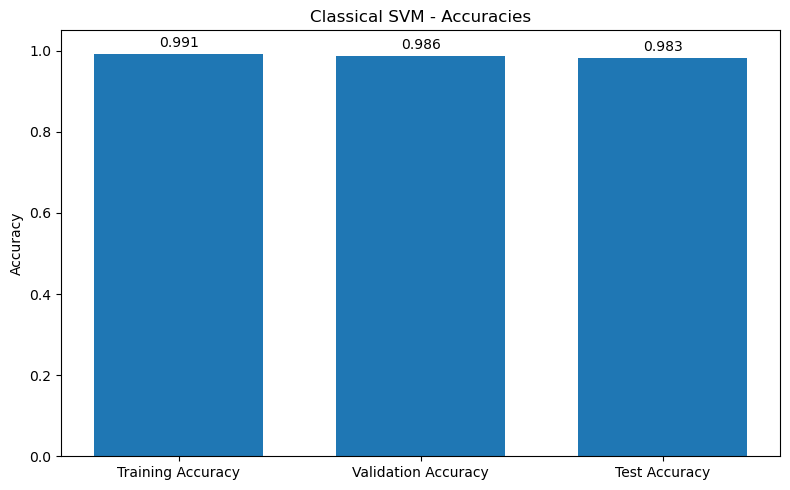

Classical SVM Bootstrap Test Accuracy: mean=0.9827 | 95% CI=(0.9654, 0.9965)


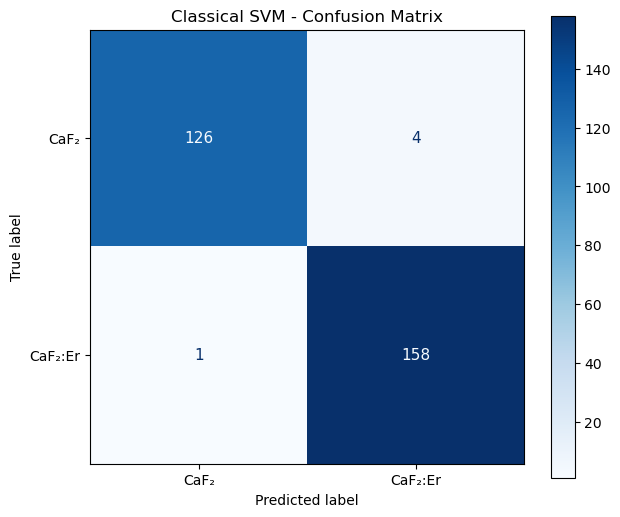

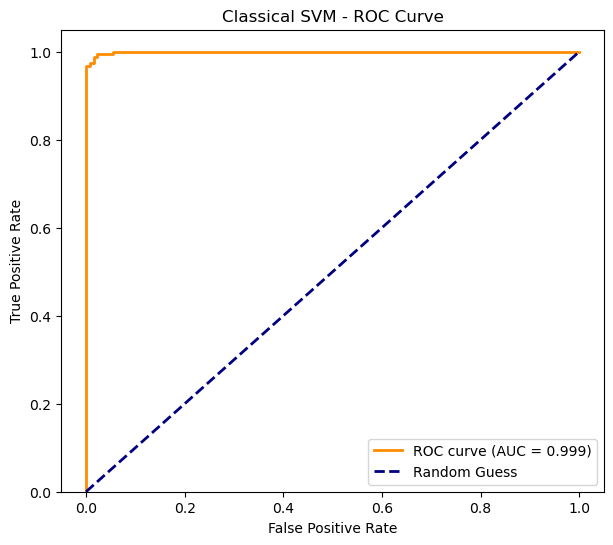

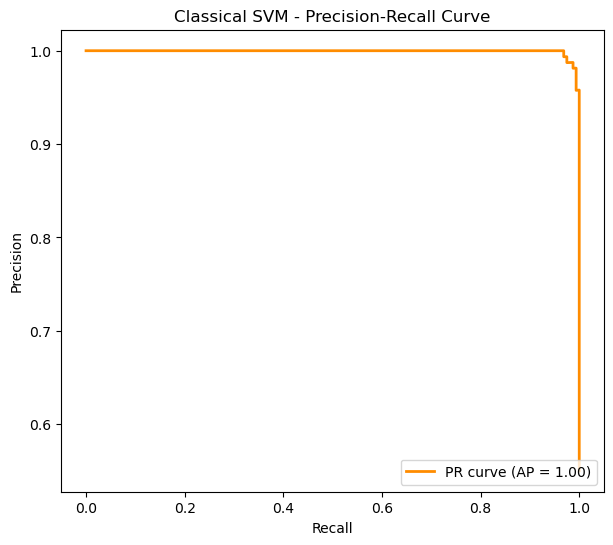

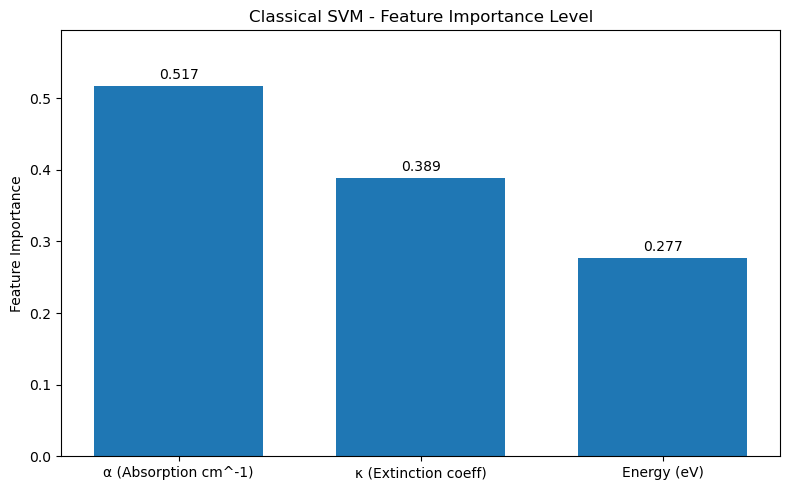

######### QSVM (simulator) #########

QSVM (simulator) - Test Classification Report:

              precision    recall  f1-score   support

        CaF₂       0.94      0.72      0.81       130
     CaF₂:Er       0.81      0.96      0.88       159

    accuracy                           0.85       289
   macro avg       0.87      0.84      0.84       289
weighted avg       0.87      0.85      0.85       289



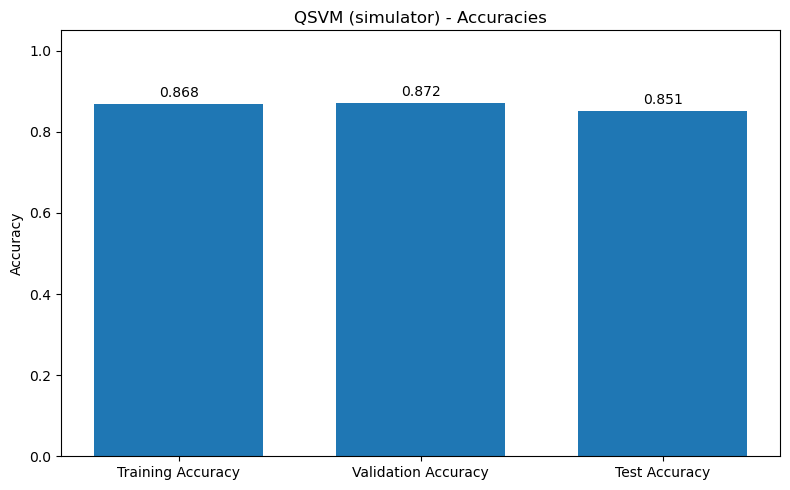

QSVM (simulator) Bootstrap Test Accuracy: mean=0.8515 | 95% CI=(0.8097, 0.8927)


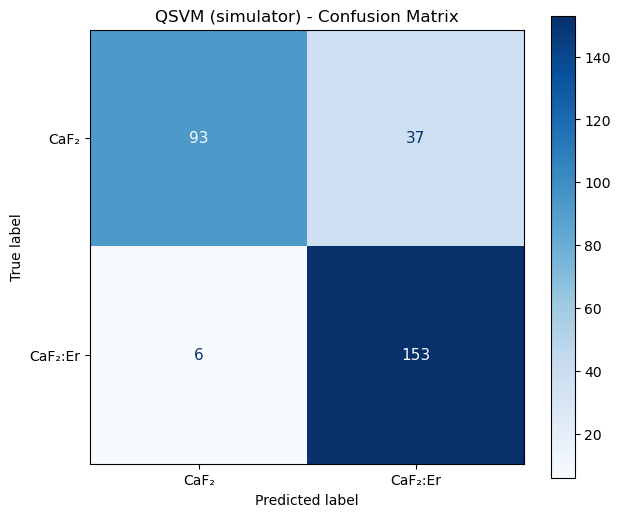

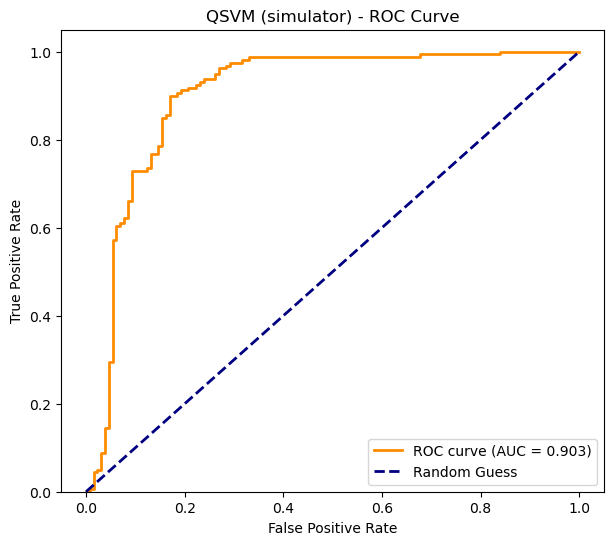

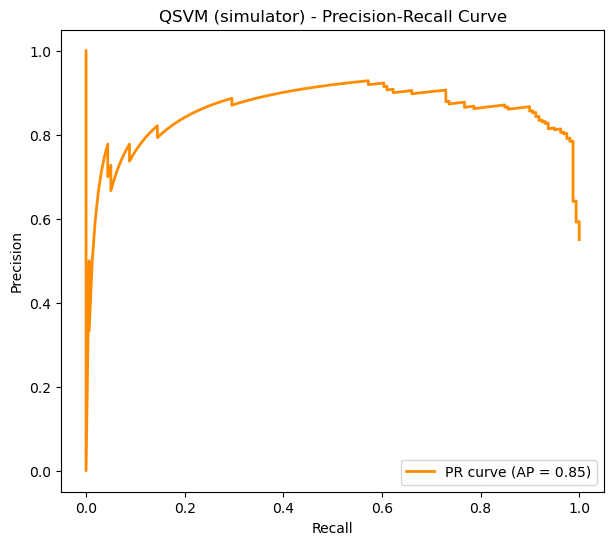

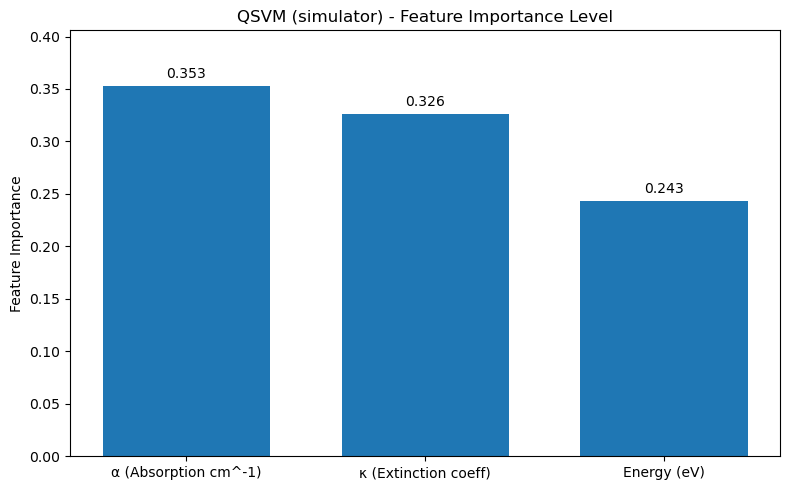

######### QSVM (IBM Hardware) #########
Hardware QSVM accuracy (train slice): 0.9166666666666666


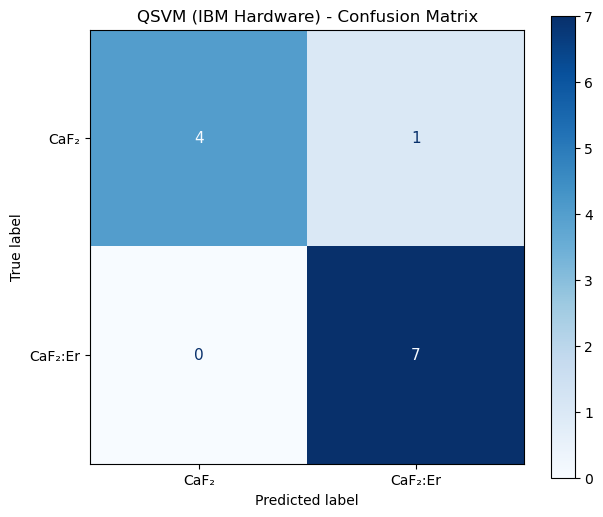

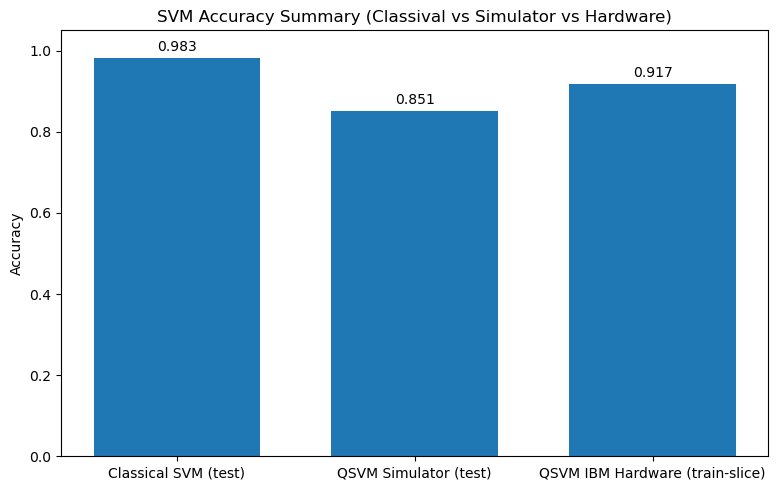

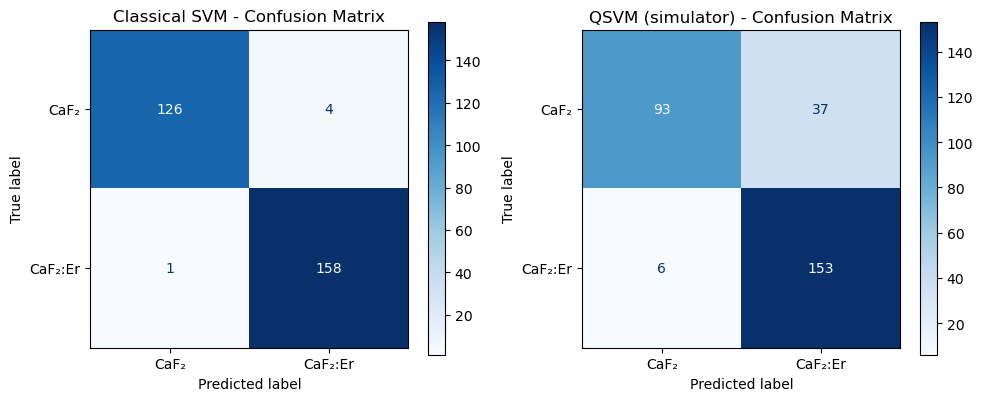

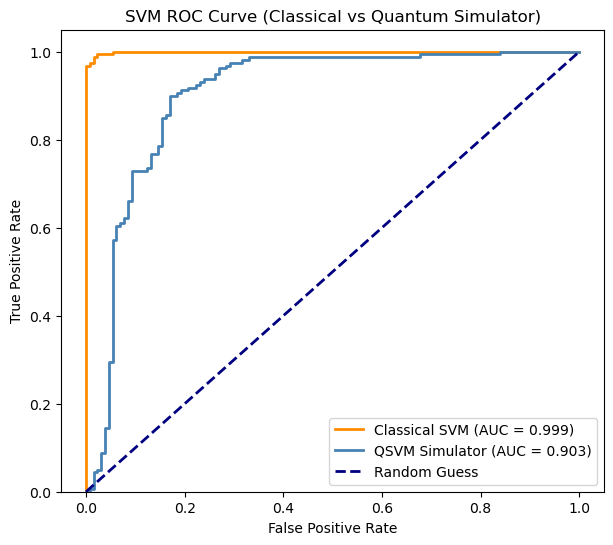

In [ ]:
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from sklearn.metrics import ( classification_report, confusion_matrix, ConfusionMatrixDisplay, 
                             roc_curve, auc, precision_recall_curve, average_precision_score )

RESULTS_DIR = "/home/albad/Quantum/Qiskit_Advocate/Github/Q-UCSpec-main-QML/qml_results"
ARTIFACT_FILE = "/home/albad/Quantum/Qiskit_Advocate/Github/Q-UCSpec-main-QML/qml_results/QSVM_meta.json"
with open(ARTIFACT_FILE, "r", encoding="utf-8") as f:
    data = json.load(f)
MODELS_DIC = {"Classical SVM":"SVM", "QSVM (simulator)":"QSVM_sim", "QSVM (IBM Hardware)":"QSVM_ibm"}

# Functions for post processing

# -----------------------------
# Bootstrap
# -----------------------------
def _bootstrap_acc(y_true, y_pred_fn, n_boot=500):
    rng = np.random.default_rng(0)
    n = len(y_true)
    accs = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        yt = y_true[idx]
        yp = y_pred_fn(idx)
        accs.append(np.mean(yp == yt))
    accs = np.array(accs)
    return float(accs.mean()), (float(np.quantile(accs, 0.025)), float(np.quantile(accs, 0.975)))

def compute_bootstrap_acc(y_true, y_pred, title, n_boot=500):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    acc_mean, acc_ci = _bootstrap_acc(
        y_true_arr,
        lambda idx: y_pred_arr[idx],
        n_boot=n_boot
    )
    print(f"{title} Bootstrap Test Accuracy: mean={acc_mean:.4f} | 95% CI=({acc_ci[0]:.4f}, {acc_ci[1]:.4f})")

# -----------------------------
# Accuracies
# -----------------------------
def plot_accuracies(results, labels, labels_dic, title):
    values = []
    new_labels = []
    for key in labels:
        if key in results:
            new_labels.append(labels_dic[key])
            values.append(results[key])
    if not new_labels:
        print("No accuracy results to plot.")
        return
    plt.figure(figsize=(8, 5))
    bars = plt.bar(new_labels, values, width=0.7)
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)
    plt.title(title + ' - Accuracies')
    for bar, v in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{v:.3f}",
            ha="center",
            va="bottom",
        )
    plt.tight_layout()
    out_path = os.path.join(RESULTS_DIR, f"acc_{MODELS_DIC[title]}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

def plot_accuracies_comparison(results_dic):
    values = []
    labels = list(results_dic)
    for key in labels:
        if key in results_dic:
            values.append(results_dic[key])
    plt.figure(figsize=(8, 5))
    bars = plt.bar(labels, values, width=0.7)
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.05)
    plt.title("SVM Accuracy Summary (Classival vs Simulator vs Hardware)")
    for bar, v in zip(bars, values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.01,
            f"{v:.3f}",
            ha="center",
            va="bottom",
        )
    plt.tight_layout()
    out_path = os.path.join(RESULTS_DIR, f"acc_QSVM_Comparison.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

# -----------------------------
# Confusion Matrix
# -----------------------------
def plot_confusion_matrix(y_true, y_pred, title, labels=["CaF₂", "CaF₂:Er"]):
    fig, ax = plt.subplots(figsize=(7, 6))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', ax=ax)
    for text in ax.texts:
        text.set_fontsize(11)
    ax.set_title(title + ' - Confusion Matrix')
    out_path = os.path.join(RESULTS_DIR, f"confusion_matrix_{MODELS_DIC[title]}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

def plot_confusion_matrix_comparison(y_true, y_pred_svm, y_pred_qsvm, labels=["CaF₂", "CaF₂:Er"]):
    fig = plt.figure(figsize=(10, 4))
    # Classical SVM
    ax1 = plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred_svm)
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp1.plot(cmap='Blues', ax=ax1, values_format="d")
    ax1.set_title('Classical SVM - Confusion Matrix')
    # Quantum SVM
    ax2 = plt.subplot(1, 2, 2)
    cm2 = confusion_matrix(y_true, y_pred_qsvm)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels)
    disp2.plot(cmap='Blues', ax=ax2, values_format="d")
    ax2.set_title('QSVM (simulator) - Confusion Matrix')
    plt.tight_layout()
    out_path = os.path.join(RESULTS_DIR, f"confusion_matrix_QSVM_Comparison.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

# -----------------------------
# ROC Curve
# -----------------------------
def plot_roc_curve(y_true, y_proba, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title + ' - ROC Curve')
    plt.legend(loc="lower right")
    out_path = os.path.join(RESULTS_DIR, f"roc_{MODELS_DIC[title]}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

def plot_roc_curve_comparison(y_true, y_proba_svm, y_proba_qsvm):
    fpr1, tpr1, _ = roc_curve(y_true, y_proba_svm)
    fpr2, tpr2, _ = roc_curve(y_true, y_proba_qsvm)
    roc_auc1 = auc(fpr1, tpr1)
    roc_auc2 = auc(fpr2, tpr2)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'Classical SVM (AUC = {roc_auc1:.3f})')
    plt.plot(fpr2, tpr2, color='steelblue', lw=2, label=f'QSVM Simulator (AUC = {roc_auc2:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('SVM ROC Curve (Classical vs Quantum Simulator)')
    plt.legend(loc="lower right")
    out_path = os.path.join(RESULTS_DIR, f"roc_QSVM_Comparison.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

# -----------------------------
# Precision-Recall Curve
# -----------------------------
def plot_pr_curve(y_true, y_proba, title):
    p, r, thresholds = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.figure(figsize=(7, 6))
    plt.plot(r, p, color='darkorange', lw=2, label=f'PR curve (AP = {ap:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title + ' - Precision-Recall Curve')
    plt.legend(loc="lower right")
    out_path = os.path.join(RESULTS_DIR, f"pr_{MODELS_DIC[title]}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

# -----------------------------
# Feature importance (permutation importance)
# -----------------------------
def plot_feature_importance(feature_importance_score, features, title):
    plt.figure(figsize=(8, 5))
    bars = plt.bar(features, feature_importance_score, width=0.7)
    plt.ylim(0, max(feature_importance_score)*1.15)
    plt.title(title + ' - Feature Importance Level')
    plt.ylabel('Feature Importance')
    for bar, v in zip(bars, feature_importance_score):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.005,
            f"{v:.3f}",
            ha="center",
            va="bottom",
        )
    plt.tight_layout()
    out_path = os.path.join(RESULTS_DIR, f"feature_importance_{MODELS_DIC[title]}.png")
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()

# Models to post process
models = ["Classical SVM", "QSVM (simulator)", "QSVM (IBM Hardware)"]
features = data["Features"]
# Post processing
for model_name in models:
    print(f"######### {model_name} #########")
    # Model data
    model_data = data["Results"][model_name]
    if model_name != "QSVM (IBM Hardware)":
        # Accuracy labels
        acc_labels = ["acc_train", "acc_val", "acc_test"]
        acc_labels_dic = {
            "acc_train": "Training Accuracy",
            "acc_val": "Validation Accuracy",
            "acc_test": "Test Accuracy",
        }
        # Classification report on test set
        print(f"\n{model_name} - Test Classification Report:\n",)
        print(classification_report(model_data["y_test"], model_data["pred_test"], labels=[0,1], target_names=["CaF₂", "CaF₂:Er"]))
        # Plot of train, validation and test accuracies
        plot_accuracies(model_data, acc_labels, acc_labels_dic, model_name)
        # Show bootstrap test accucary
        compute_bootstrap_acc(model_data["y_test"], model_data["pred_test"], model_name, n_boot=500)
        # Plot of confusion matrix on test set
        plot_confusion_matrix(model_data["y_test"], model_data["pred_test"], model_name, labels=["CaF₂", "CaF₂:Er"])
        # Plot of ROC curve on test set
        plot_roc_curve(model_data["y_test"], model_data["y_test_score"], model_name)
        # Plot of Precision-Recall curve on test set
        plot_pr_curve(model_data["y_test"], model_data["y_test_score"], model_name)
        # Plot of feature importance level
        plot_feature_importance(model_data["feature_score"], features, model_name)
    else:
        print("Hardware QSVM accuracy (train slice):", model_data["acc_train"])
        # Plot of confusion matrix on test set
        plot_confusion_matrix(model_data["y_train"], model_data["pred_train"], model_name, labels=["CaF₂", "CaF₂:Er"])

# Summary and comparison plots
results = data["Results"]
summary_data = {"Classical SVM (test)": results["Classical SVM"]["acc_test"], 
                "QSVM Simulator (test)": results["QSVM (simulator)"]["acc_test"], 
                "QSVM IBM Hardware (train-slice)": results["QSVM (IBM Hardware)"]["acc_train"]}

plot_accuracies_comparison(summary_data)
plot_confusion_matrix_comparison(results["Classical SVM"]["y_test"], results["Classical SVM"]["pred_test"], results["QSVM (simulator)"]["pred_test"], labels=["CaF₂", "CaF₂:Er"])
plot_roc_curve_comparison(results["Classical SVM"]["y_test"], results["Classical SVM"]["y_test_score"],  results["QSVM (simulator)"]["y_test_score"])